# Necessary Imports

In [ ]:
!pip install opencv-python-headless numpy matplotlib

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper Functions

In [ ]:
# Function to create a synthetic image with a circle
def make_circle(radius=50, image_size=(256, 256)):
    image = np.zeros(image_size, dtype=np.uint8)
    center = (image_size[1] // 2, image_size[0] // 2)
    cv2.circle(image, center, radius, 255, -1)
    return image

# Function to create a synthetic image with a square
def make_square(side_length=100, image_size=(256, 256)):
    image = np.zeros(image_size, dtype=np.uint8)
    top_left = (image_size[1] // 2 - side_length // 2, image_size[0] // 2 - side_length // 2)
    bottom_right = (image_size[1] // 2 + side_length // 2, image_size[0] // 2 + side_length // 2)
    cv2.rectangle(image, top_left, bottom_right, 255, -1)
    return image

# Function to apply DoG filter
def dog_filter(image, sigma1, sigma2):
    blur1 = cv2.GaussianBlur(image, (0, 0), sigma1)
    blur2 = cv2.GaussianBlur(image, (0, 0), sigma2)
    dog_image = blur1 - blur2
    return dog_image

# Function to convert the coloured image in to gray
def gray_img(img_path):
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  return image

# Function for applying the Gabor filters and visualizing
def visualize_gabor_filters(image, ksize_values, lambda_values):
    sigma = 4.0
    theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
    gamma = 0.5
    psi = 0

    fig, axs = plt.subplots(len(ksize_values) * len(lambda_values), len(theta_values), figsize=(20, 15))
    axs = axs.flatten()

    index = 0
    for i, ksize in enumerate(ksize_values):
        for j, lambd in enumerate(lambda_values):
            for k, theta in enumerate(theta_values):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
                filtered_image = cv2.filter2D(image, cv2.CV_64F, kernel)
                edge_image = np.abs(filtered_image)

                # Display the edges detected for this combination of ksize, lambda, and theta
                axs[index].imshow(edge_image, cmap='gray')
                axs[index].set_title(f'ksize={ksize}, lambda={lambd}, theta={np.degrees(theta)}°')
                axs[index].axis('off')
                index += 1

    plt.tight_layout()
    plt.show()

# Different sigma values

In [ ]:
# Experiment with different sigma values for DoG
sigma_pairs = [(0.5, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (5.0, 6.0)]

# Plotting the Circle and Square

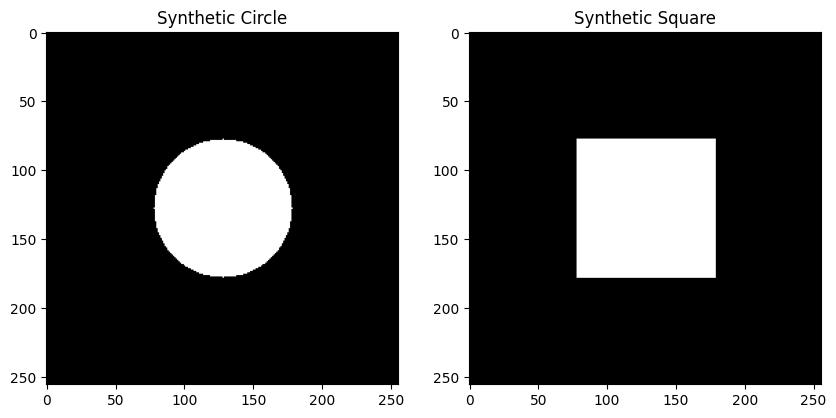

In [ ]:
# Create and display synthetic images
circle_image = make_circle()
square_image = make_square()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Synthetic Circle')
plt.imshow(circle_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Synthetic Square')
plt.imshow(square_image, cmap='gray')
plt.show()

# Trying Different values for sigma while applying the DOG on square and Circle

In [ ]:
def sigma_dogs(img, sigma_pair):
    if img is None or img.size == 0:
        raise ValueError("Input image is empty or not loaded correctly.")
    if len(img.shape) == 2:
        gray_image = img
    else:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply DoG for the given sigma pair
    sigma1, sigma2 = sigma_pair
    dog_image = dog_filter(gray_image, sigma1, sigma2)

    # Display the result
    plt.figure(figsize=(2.5, 2.5))
    plt.title(f'DoG with sigma1={sigma1}, sigma2={sigma2}')
    plt.imshow(dog_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return dog_image



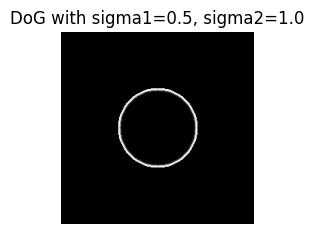

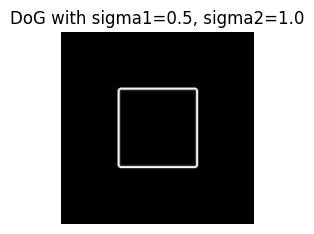

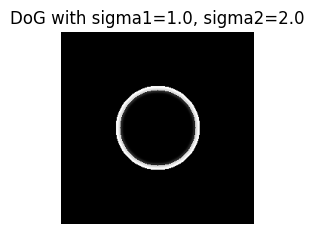

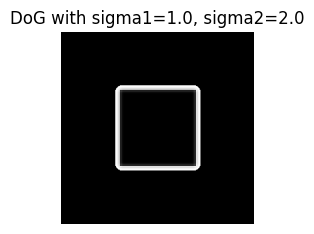

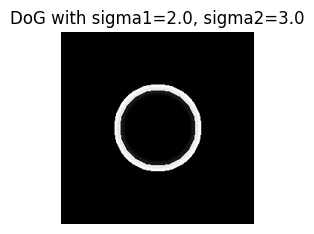

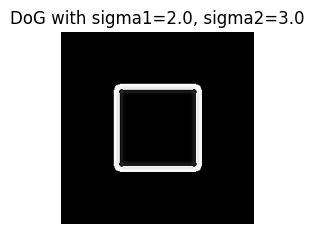

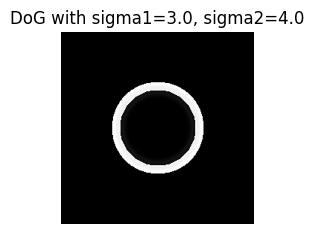

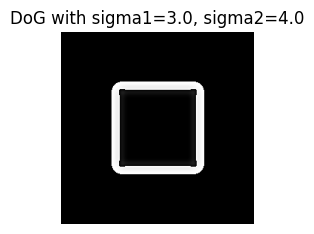

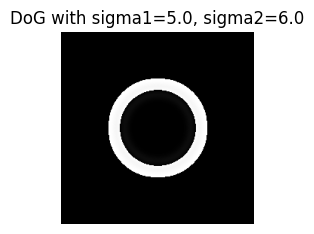

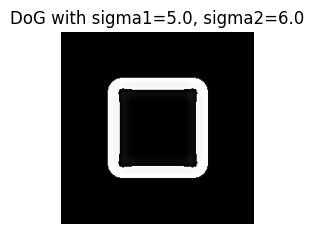

In [ ]:
for pair in sigma_pairs:
  # Apply DoG and get the resulting image
  dog_image_circle = sigma_dogs(circle_image, pair)
  dog_image_square = sigma_dogs(square_image, pair)

# Checking different filter sizes and lambda values for Gabor filters

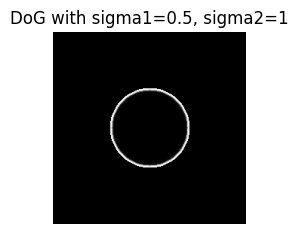

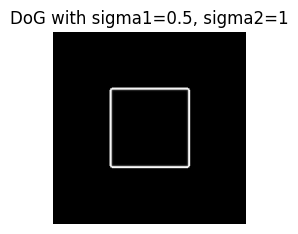

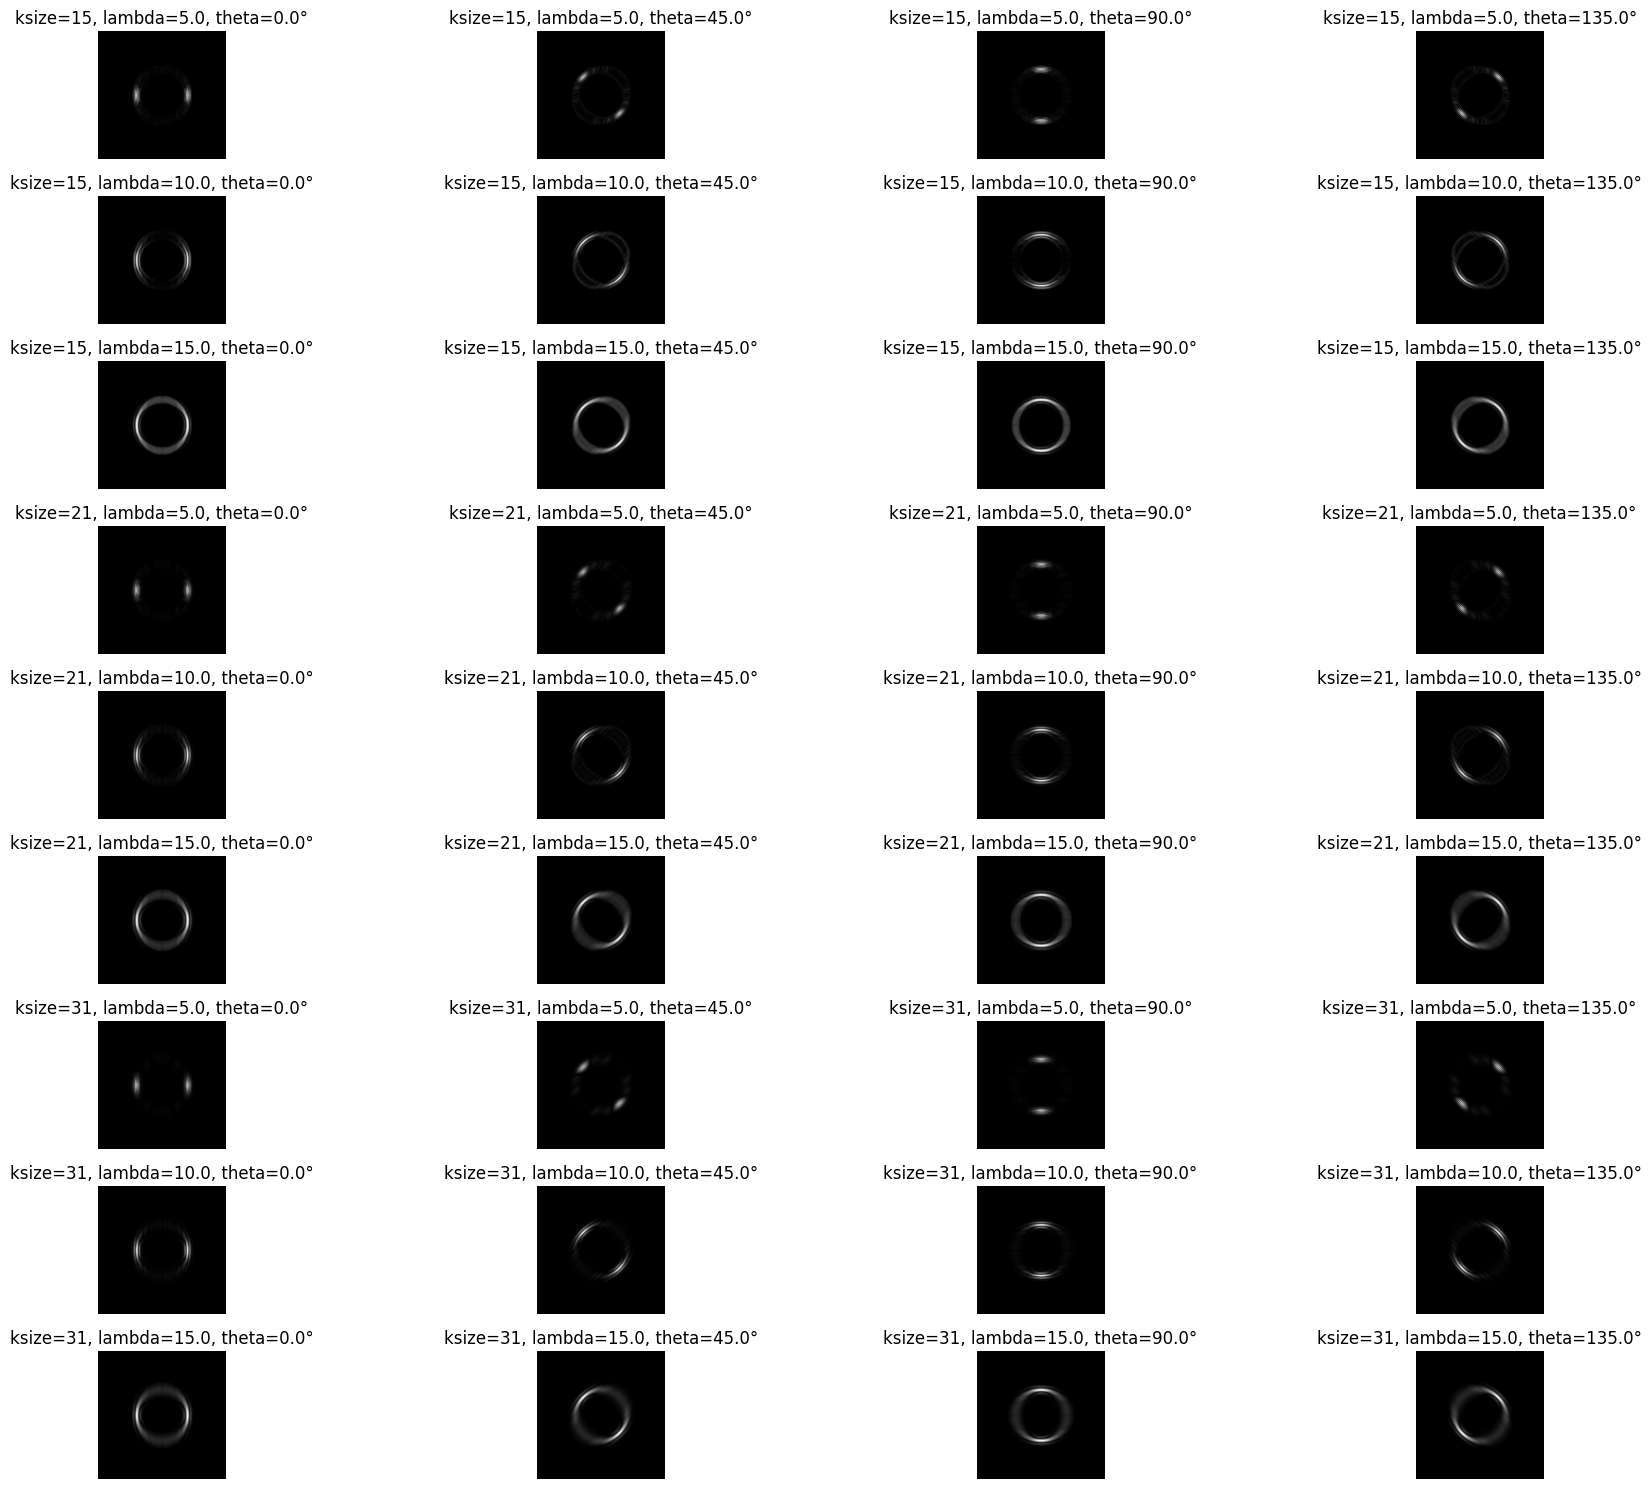

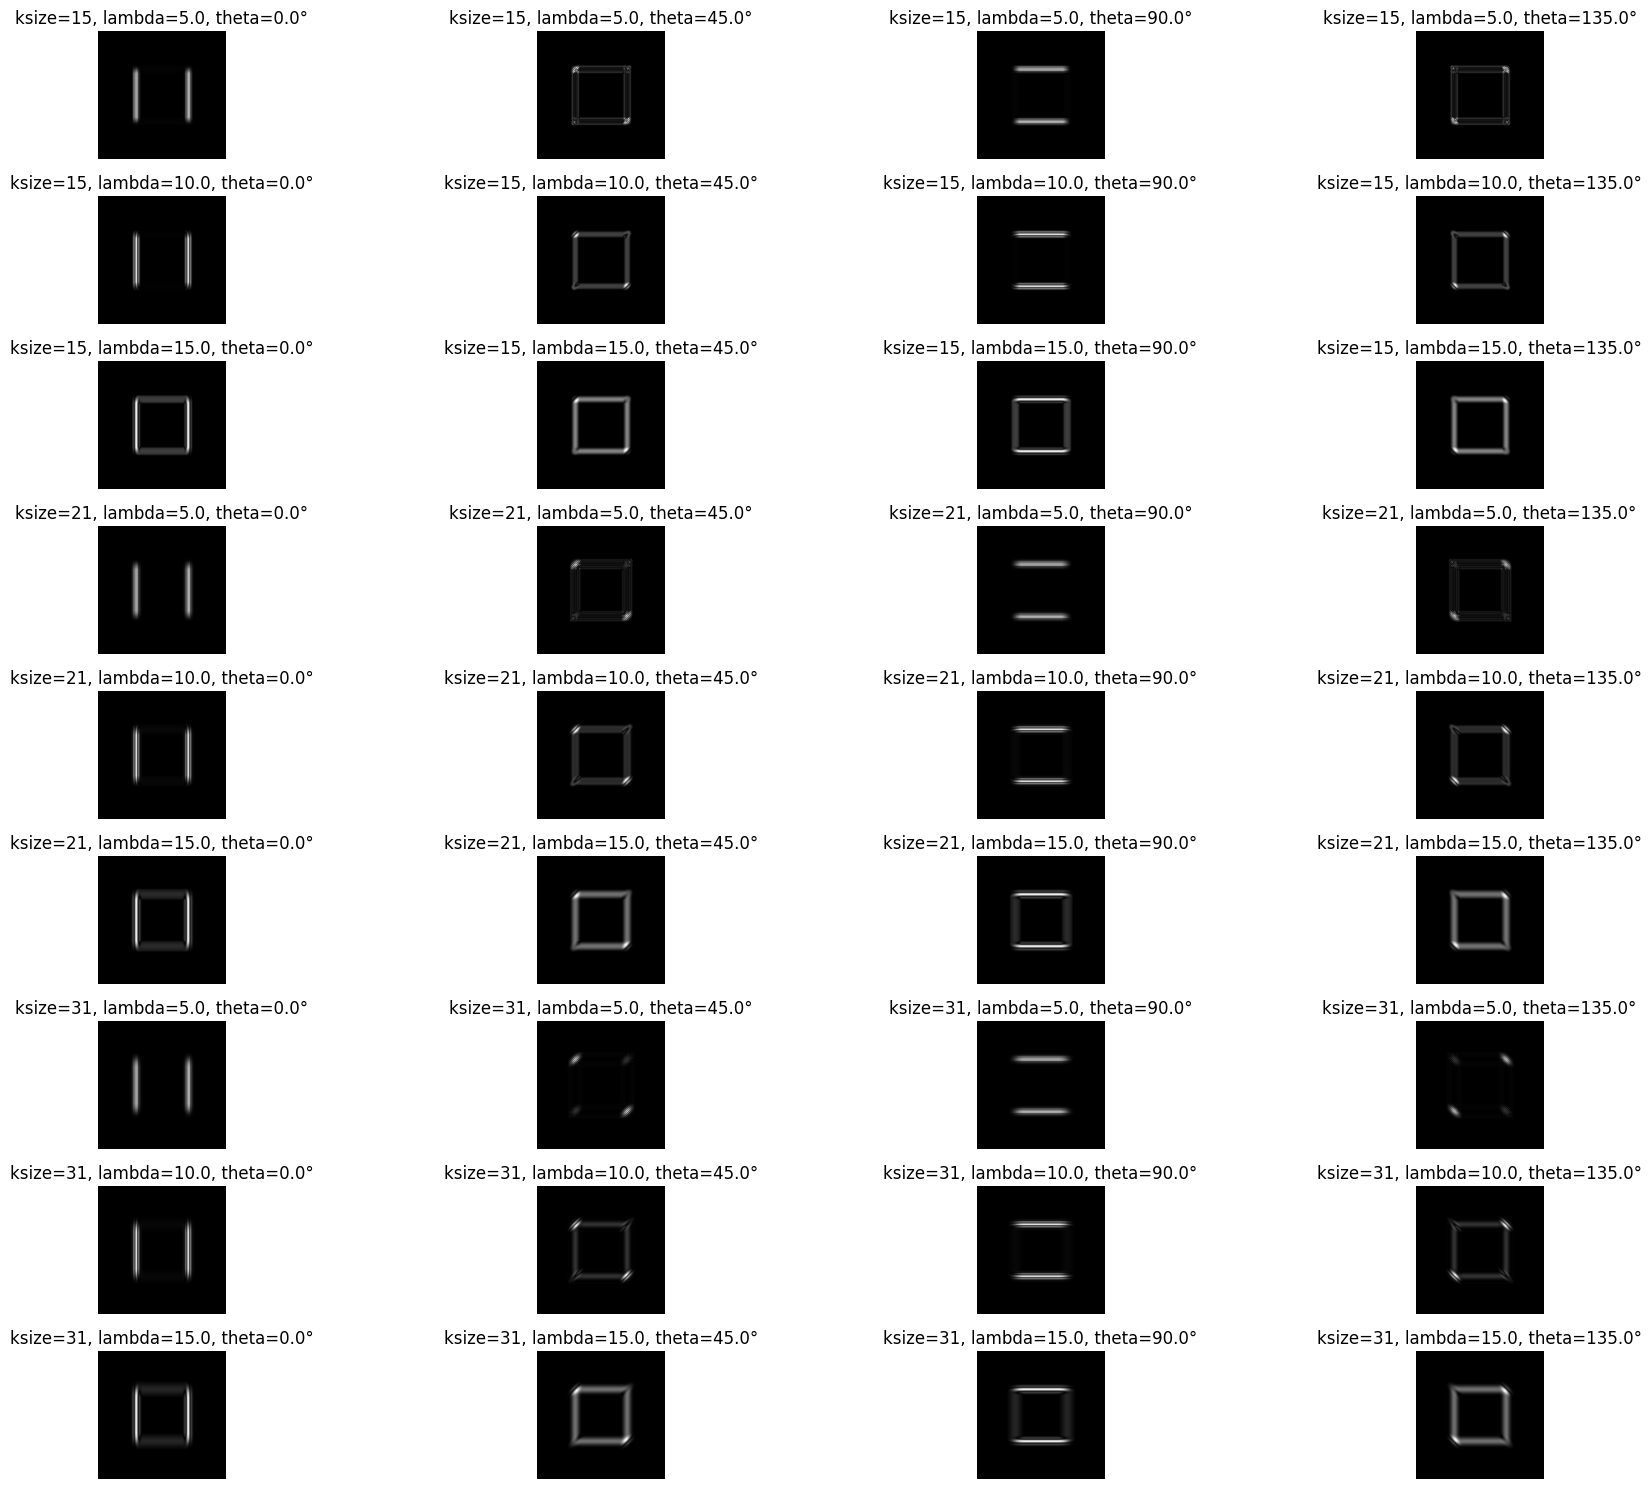

In [ ]:
ksize_values = [15, 21, 31] # different ksize and lambda values for Gabor filters
lambda_values = [5.0, 10.0, 15.0]
best_pair = [(0.5, 1)]
dog_image_circle = sigma_dogs(circle_image, best_pair[0])
dog_image_square = sigma_dogs(square_image, best_pair[0])

# Apply Gabor filters on the DoG image for the circle
visualize_gabor_filters(dog_image_circle, ksize_values, lambda_values)

# Apply Gabor filters on the DoG image for the square
visualize_gabor_filters(dog_image_square, ksize_values, lambda_values)

# Functions for WTA and Gabor Filters on the Images

In [ ]:
# Function to apply Winner-Take-All and normalization
def wta_and_normalize(edge_images, threshold=0.1):
    stacked_edges = np.stack([edge_images[angle] for angle in edge_images.keys()], axis=-1)

    max_edges = np.max(stacked_edges, axis=-1)
    avg_edges = np.mean(stacked_edges, axis=-1)

    normalized_edges = max_edges / (avg_edges + 1e-5)  # To avoid division by zero

    # Apply thresholding to ignore spurious edges
    final_edges = np.where(normalized_edges > threshold, max_edges, 0)

    return final_edges

# Function to apply Gabor filters and WTA on the image
def process_img(image, ksize_values, lambda_values):
    if image is None or image.size == 0:
          raise ValueError("Input image is empty or not loaded correctly.")
    # Apply Gabor filters
    edge_images = {}
    sigma = 4.0
    theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    gamma = 0.5
    psi = 0

    for ksize in ksize_values:
        for lambd in lambda_values:
            for theta in theta_values:
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
                filtered_image = cv2.filter2D(image, cv2.CV_64F, kernel)
                edge_images[(ksize, lambd, np.degrees(theta))] = np.abs(filtered_image)

    # Apply WTA and normalization
    final_edge_image = wta_and_normalize(edge_images)

    return final_edge_image

def display_edges(sigma_pairs, circle_image, square_image, ksize_values, lambda_values):
    num_pairs = len(sigma_pairs)

    plt.figure(figsize=(15, num_pairs * 3))

    for idx, sigma_pair in enumerate(sigma_pairs):
        dog_image_circle = sigma_dogs(circle_image, sigma_pair)
        dog_image_square = sigma_dogs(square_image, sigma_pair)

        final_edges_circle = process_img(dog_image_circle, ksize_values, lambda_values)
        final_edges_square = process_img(dog_image_square, ksize_values, lambda_values)

        # Plot the DoG and Final Edge images for the circle
        if circle_image is not None:
          plt.subplot(num_pairs, 4, idx * 4 + 1)
          plt.imshow(dog_image_circle, cmap='gray')
          plt.title(f'sigma={sigma_pair}', fontsize=8)
          plt.axis('off')

          plt.subplot(num_pairs, 4, idx * 4 + 2)
          plt.imshow(final_edges_circle, cmap='gray')
          plt.title(f'edges_sigma={sigma_pair}', fontsize=8)
          plt.axis('off')
        else:
          continue
        # Plot the DoG and Final Edge images for the square
        if square_image is not None:
          plt.subplot(num_pairs, 4, idx * 4 + 3)
          plt.imshow(dog_image_square, cmap='gray')
          plt.title(f'sigma={sigma_pair}', fontsize=8)
          plt.axis('off')

          plt.subplot(num_pairs, 4, idx * 4 + 4)
          plt.imshow(final_edges_square, cmap='gray')
          plt.title(f'edges_sigma={sigma_pair}', fontsize=8)
          plt.axis('off')
        else:
          continue

    plt.tight_layout()
    plt.show()

<Figure size 1500x1500 with 0 Axes>

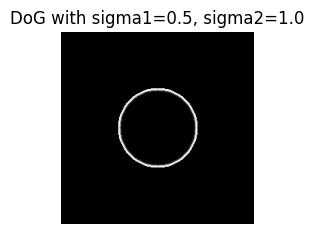

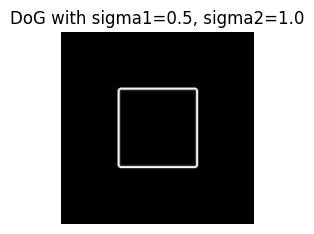

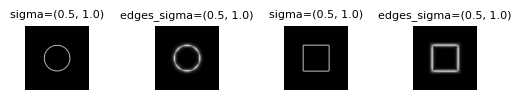

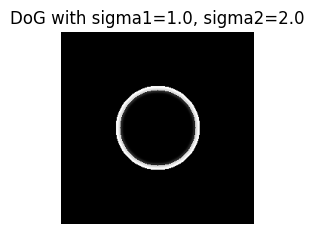

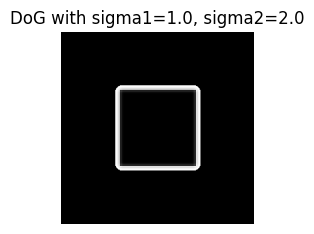

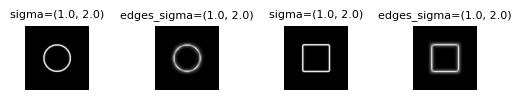

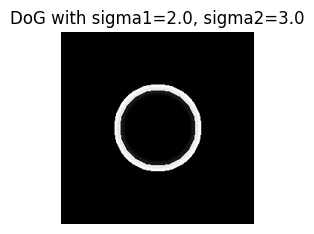

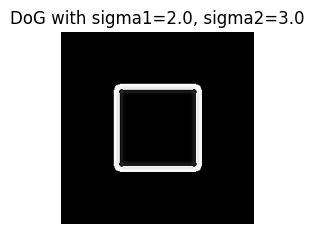

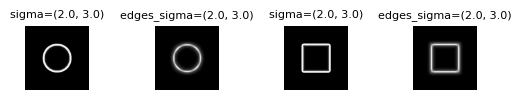

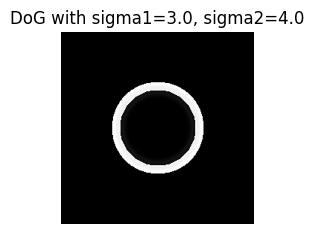

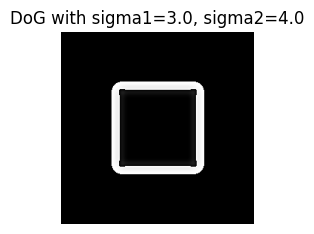

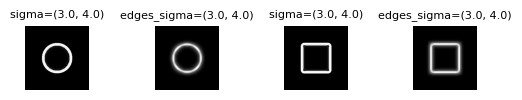

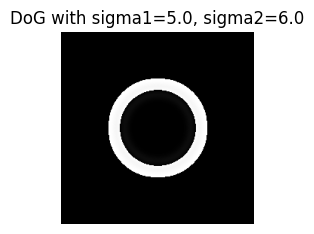

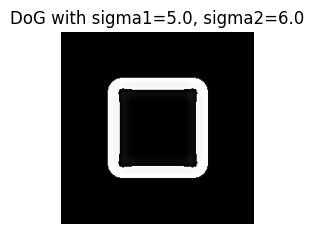

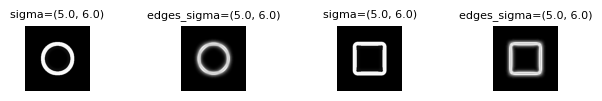

In [ ]:
# Run the experimentation and display results
display_edges(sigma_pairs, circle_image, square_image, ksize_values, lambda_values)

# Testing on the original Image

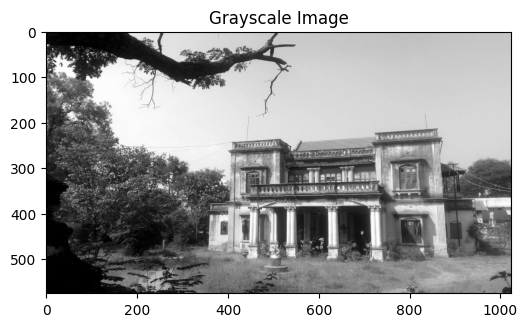

In [ ]:
# Load the image from Google Drive
image_path = '/content/04-old-house.jpg'
gray_image = gray_img(image_path)

# Display the grayscale image
plt.figure(figsize=(6, 6))
plt.title('Grayscale Image')
plt.imshow(gray_image, cmap='gray')
plt.show()

# Applying Dog

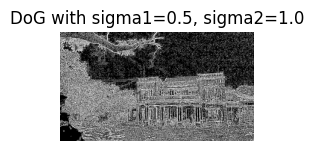

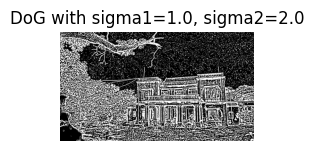

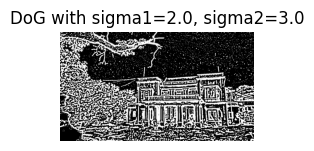

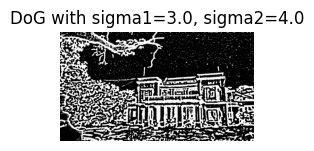

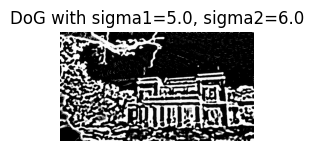

In [ ]:
for pair in sigma_pairs:
  dog_image = sigma_dogs(gray_image, pair)

# Gabor filter in the images with best sigma values

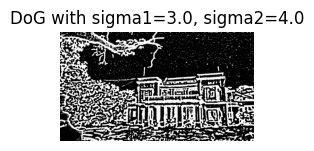

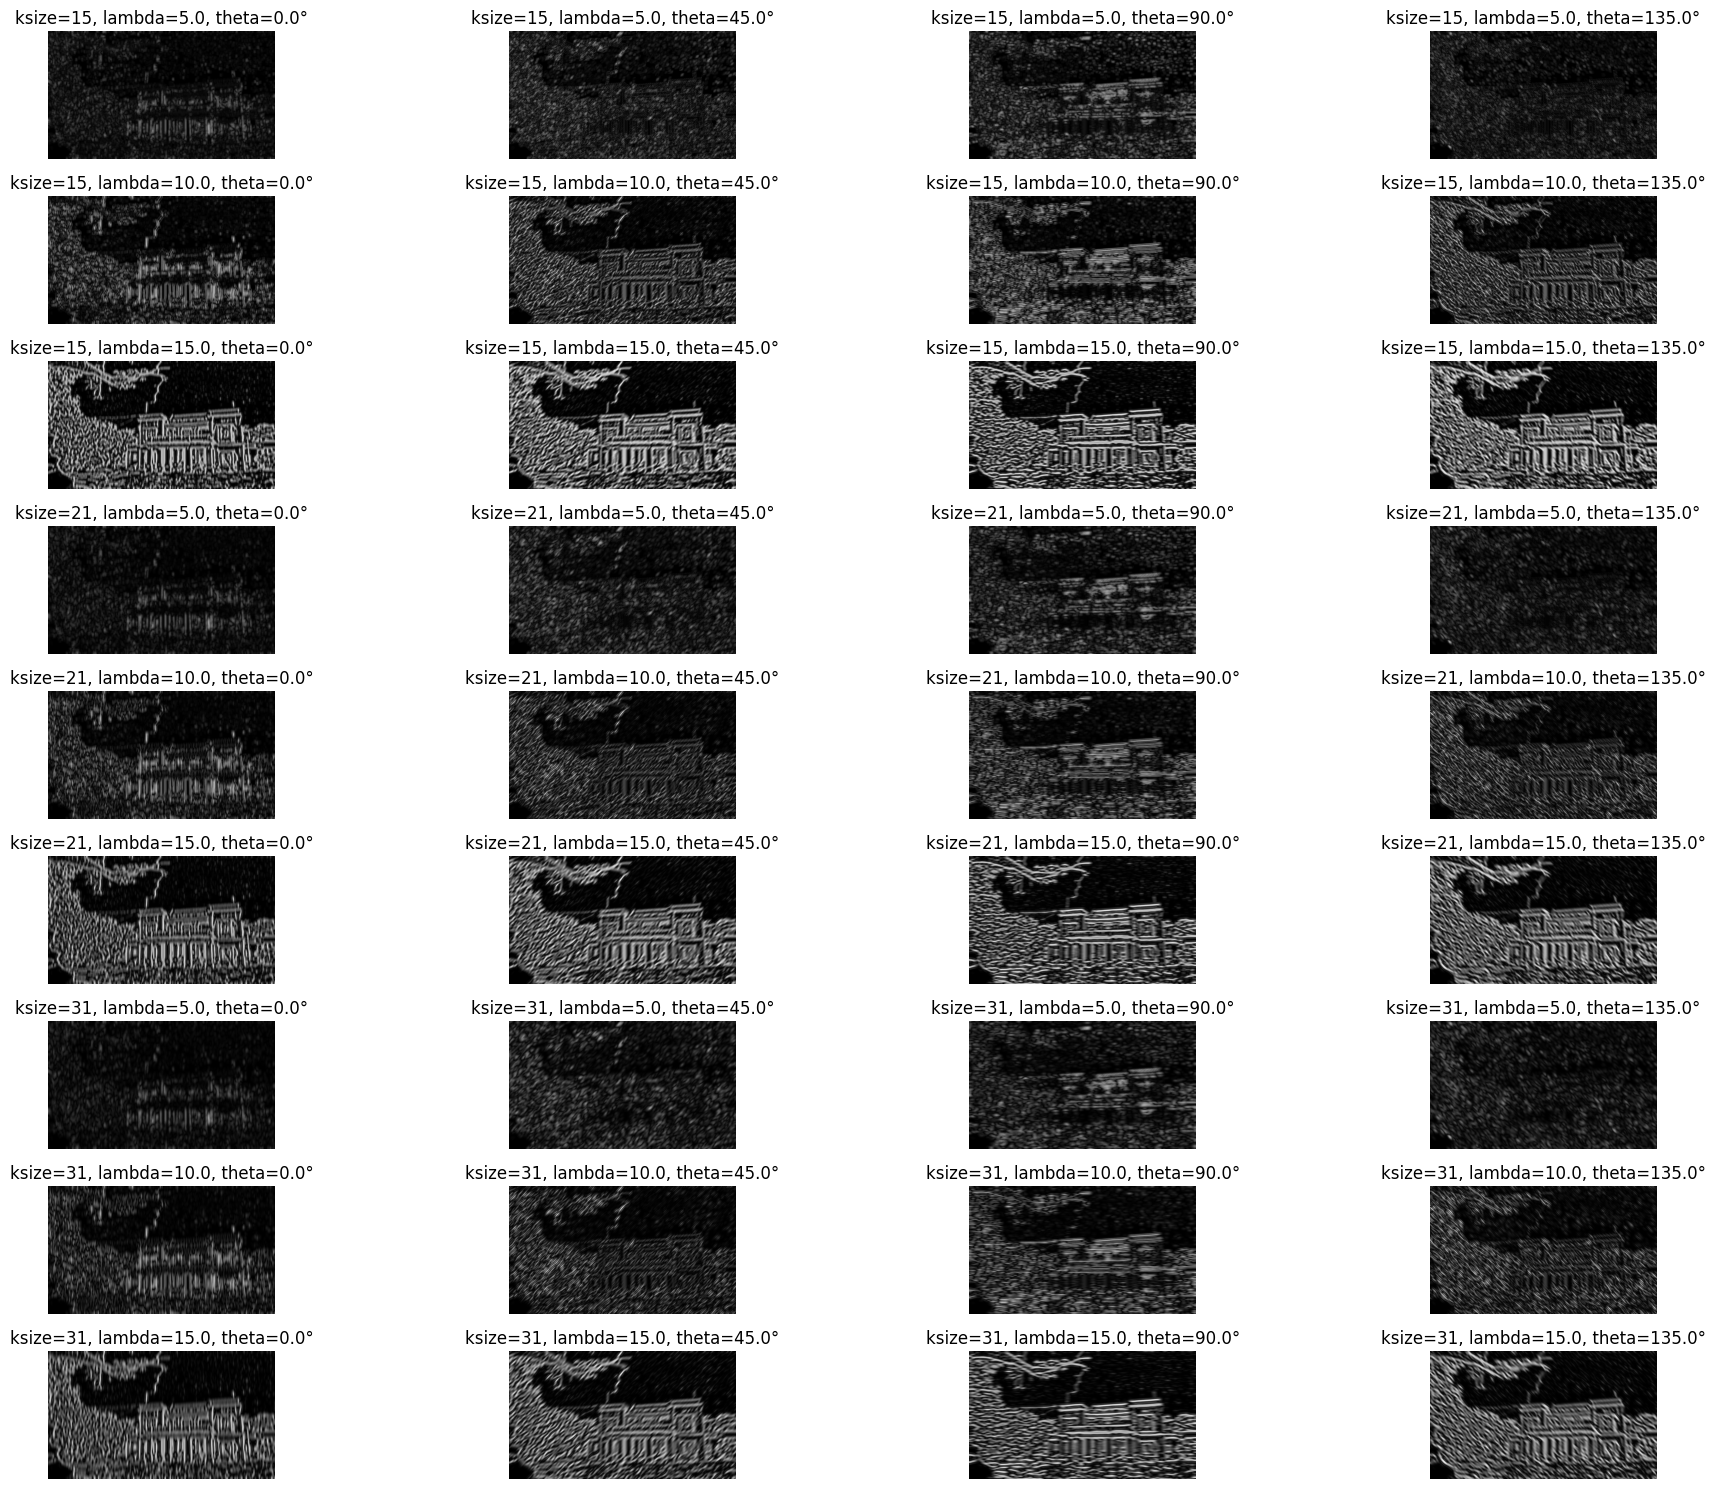

In [ ]:
best_sigmas = [(3.0, 4.0)]
dog_image = sigma_dogs(gray_image, best_sigmas[0])
visualize_gabor_filters(dog_image, ksize_values, lambda_values)

In [ ]:
def display_img_results(sigma_pairs, image, ksize_values, lambda_values):
    num_pairs = len(sigma_pairs)

    plt.figure(figsize=(15, num_pairs * 2.5))

    for idx, sigma_pair in enumerate(sigma_pairs):
        dog_image = sigma_dogs(image, sigma_pair)

        final_edges = process_img(dog_image, ksize_values, lambda_values)

        plt.subplot(num_pairs, 2, idx * 2 + 1)
        plt.imshow(dog_image, cmap='gray')
        plt.title(f'sigma={sigma_pair}', fontsize=8)
        plt.axis('off')

        plt.subplot(num_pairs, 2, idx * 2 + 2)
        plt.imshow(final_edges, cmap='gray')
        plt.title(f'edges_sigma={sigma_pair}', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

<Figure size 1500x1250 with 0 Axes>

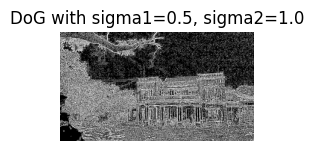

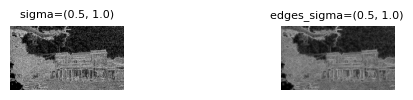

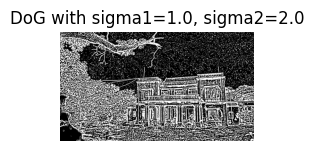

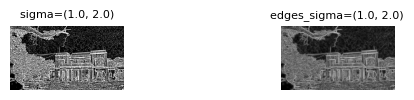

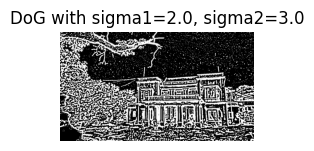

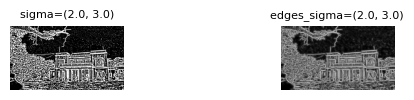

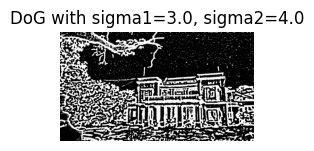

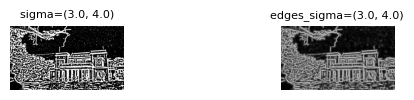

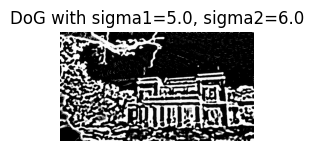

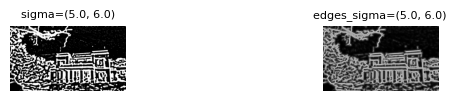

In [ ]:
# Display edges using the gabor filters -> WtA
display_img_results(sigma_pairs, gray_image, ksize_values, lambda_values)